In [1]:
import numpyro
import jax
import numpy as np
import scipy.stats as stats
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import arviz as az
from scipy.interpolate import BSpline

sns.set()
numpyro.set_host_device_count(4)

## 1. Load data, split into train and test sets

In [2]:
wells = pd.read_csv("wells/wells_raw.csv")
train_id = pd.read_csv("wells/train_id.csv").squeeze() - 1
y_train = wells.iloc[train_id]["switch"]
y_test = wells.loc[~wells.index.isin(train_id)]["switch"]
wells["intercept"] = 1

In [3]:
np.random.seed(1)
train_id = wells.sample(n=2000).index
# train_id = pd.read_csv('~/random-assorted-notebooks/wells/train_id.csv').squeeze().to_numpy()-1
test_id = wells.index[~wells.index.isin(train_id)]
y_train = wells.loc[train_id, "switch"].to_numpy()
y_test = wells.loc[test_id, "switch"].to_numpy()

## 2. Feature engineering

In [4]:
def bs(x, knots, degree):
    """Replicates bs from splines package in R."""
    padded_knots = np.hstack(
        [[x.min()] * (degree + 1), knots, [x.max()] * (degree + 1)]
    )
    return pd.DataFrame(BSpline(padded_knots, np.eye(len(padded_knots) - degree - 1), degree)(x)[:, 1:], index=x.index)


knots = np.quantile(wells.loc[train_id, "logarsenic"], np.linspace(0.1, 0.9, num=10))
B1 = bs(wells["logarsenic"], knots=knots, degree=3)
knots = np.quantile(wells.loc[train_id, "logarsenic"], np.linspace(0.05, 0.95, num=10))
B2 = bs(wells["logarsenic"], knots=knots, degree=3)
knots = np.quantile(wells.loc[train_id, "dist100"], np.linspace(0.1, 0.9, num=10))
B3 = bs(wells["dist100"], knots=knots, degree=3)

In [5]:
wells["intercept"] = 1
X = wells.loc[
    train_id,
    ["intercept", "dist100", "arsenic", "assoc", "edu1", "edu2", "edu3"],
].to_numpy()
X2 = wells.loc[
    train_id,
    ["intercept", "dist100", "logarsenic", "assoc", "edu1", "edu2", "edu3"],
].to_numpy()
X3 = wells.loc[
    train_id,
    [
        "intercept",
        "dist100",
        "arsenic",
        "asthird",
        "asSquare",
        "assoc",
        "edu1",
        "edu2",
        "edu3",
    ],
].to_numpy()
X4 = pd.concat(
    [
        wells.loc[
            train_id,
            ["intercept", "dist100", "assoc", "edu1", "edu2", "edu3"],
        ],
        B1.loc[train_id],
    ],
    axis=1,
).to_numpy()
X5 = pd.concat(
    [
        wells.loc[
            train_id,
            ["intercept", "logarsenic", "assoc", "edu1", "edu2", "edu3"],
        ],
        B3.loc[train_id],
    ],
    axis=1,
).to_numpy()
X6 = wells.loc[
    train_id,
    ["intercept", "dist100", "logarsenic", "assoc", "educ"]
].to_numpy()

X_test = wells.loc[
    test_id,
    ["intercept", "dist100", "arsenic", "assoc", "edu1", "edu2", "edu3"],
].to_numpy()
X2_test = wells.loc[
    test_id,
    ["intercept", "dist100", "logarsenic", "assoc", "edu1", "edu2", "edu3"],
].to_numpy()
X3_test = wells.loc[
    test_id,
    [
        "intercept",
        "dist100",
        "arsenic",
        "asthird",
        "asSquare",
        "assoc",
        "edu1",
        "edu2",
        "edu3",
    ],
].to_numpy()
X4_test = pd.concat(
    [
        wells.loc[
            test_id,
            ["intercept", "dist100", "assoc", "edu1", "edu2", "edu3"],
        ],
        B1.loc[test_id],
    ],
    axis=1,
).to_numpy()
X5_test = pd.concat(
    [
        wells.loc[
            test_id,
            ["intercept", "logarsenic", "assoc", "edu1", "edu2", "edu3"],
        ],
        B3.loc[test_id],
    ],
    axis=1,
).to_numpy()
X6_test = wells.loc[
    test_id,
    ["intercept", "dist100", "logarsenic", "assoc", "educ"]
].to_numpy()

In [6]:
train_x_list = [X, X2, X3, X4, X5, X6]
train_x_test_list = [X_test, X2_test, X3_test, X4_test, X5_test, X6_test]
K = len(train_x_list)

## 3. Train six different models

In [7]:
def logistic(x, y=None):
    beta = numpyro.sample(
        "beta", numpyro.distributions.Normal(0, 3), sample_shape=(x.shape[1],)
    )
    logits = numpyro.deterministic("logits", jax.numpy.matmul(x, beta))

    numpyro.sample(
        "obs",
        numpyro.distributions.Bernoulli(logits=logits),
        obs=y,
    )

In [8]:
fit_list = []
for k in range(K):
    sampler = numpyro.infer.NUTS(logistic)
    mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
    mcmc.run(
        jax.random.PRNGKey(0),
        x=train_x_list[k],
        y=y_train,
    )
    fit_list.append(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## 4. Get estimates of leave-one-out cross-validated score for each training point

In [9]:
def find_point_wise_loo_score(fit):
    return az.loo(az.from_numpyro(fit), pointwise=True, scale="log").loo_i.values


lpd_point = np.vstack([find_point_wise_loo_score(fit) for fit in fit_list]).T

lpd_point.shape

(2000, 6)

## 5. Prepare stacking datasets

In [10]:
dist100_median = wells.loc[wells.index[train_id], "dist100"].median()
logarsenic_median = wells.loc[wells.index[train_id], "logarsenic"].median()
wells["dist100_l"] = (wells["dist100"] - dist100_median).clip(upper=0)
wells["dist100_r"] = (wells["dist100"] - dist100_median).clip(lower=0)
wells["logarsenic_l"] = (wells["logarsenic"] - logarsenic_median).clip(upper=0)
wells["logarsenic_r"] = (wells["logarsenic"] - logarsenic_median).clip(lower=0)

stacking_features = [
        "edu0",
        "edu1",
        "edu2",
        "edu3",
        "assoc_half",
        "dist100_l",
        "dist100_r",
        "logarsenic_l",
        "logarsenic_r",
    ]
X_stacking_train = wells.loc[train_id, stacking_features].to_numpy()
X_stacking_test = wells.loc[test_id, stacking_features].to_numpy()

## 6. Define stacking model

In [11]:
def stacking(
    X,
    N,
    d,
    d_discrete,
    X_test,
    N_test,
    lpd_point,
    K,
    tau_mu,
    tau_sigma,
):
    assert X.shape == (N, d)
    assert X_test.shape == (N_test, d)
    assert lpd_point.shape == (N, K)

    exp_lpd_point = jax.numpy.exp(lpd_point)

    beta_con = numpyro.sample(
        "beta_con",
        numpyro.distributions.Normal(0, 1),
        sample_shape=(K - 1, d - d_discrete),
    )
    tau = numpyro.sample(
        "tau", numpyro.distributions.Normal(0, 1), sample_shape=(K - 1, d_discrete)
    )

    mu = numpyro.sample(
        "mu",
        numpyro.distributions.Normal(0, tau_mu),
        sample_shape=(K - 1,),
    )
    sigma = numpyro.sample(
        "sigma",
        numpyro.distributions.TruncatedNormal(low=0, loc=0, scale=tau_sigma),
        sample_shape=(K - 1,),
    )

    beta = numpyro.deterministic(
        "beta",
        jax.numpy.vstack(
            [
                jax.numpy.hstack([mu[k] + sigma[k] * tau[k], beta_con[k]])
                for k in range(K - 1)
            ],
        ),
    )
    assert beta.shape == (K - 1, d)

    f = jax.numpy.hstack(
        [
            jax.numpy.vstack(
                [jax.numpy.matmul(X, beta[k]) for k in range(K - 1)],
            ).T,
            jax.numpy.zeros((N, 1)),
        ]
    )
    assert f.shape == (N, K)

    w = numpyro.deterministic("w", jax.nn.softmax(f))

    logp = jax.numpy.log((exp_lpd_point * w).sum(axis=1))
    assert logp.shape == (N,)

    numpyro.factor("logp", jax.numpy.sum(logp))

    f_test = jax.numpy.hstack(
        [
            jax.numpy.vstack(
                [jax.numpy.matmul(X_test, beta[k]) for k in range(K - 1)],
            ).T,
            jax.numpy.zeros((N_test, 1)),
        ]
    )
    numpyro.deterministic(
        "f_test",
        f_test,
    )

In [12]:
sampler = numpyro.infer.NUTS(stacking)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    X=X_stacking_train,
    N=X_stacking_train.shape[0],
    d=X_stacking_train.shape[1],
    d_discrete=4,
    X_test=X_stacking_test,
    N_test=X_stacking_test.shape[0],
    lpd_point=lpd_point,
    K=lpd_point.shape[1],
    tau_mu=1.0,
    tau_sigma=0.5,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## 7. Let's check how the weights vary over the input

In [13]:
w = mcmc.get_samples()["w"].mean(axis=0)

In [14]:
w

DeviceArray([[0.09732632, 0.1362955 , 0.12627405, 0.17816992, 0.34175807,
              0.1201761 ],
             [0.09398058, 0.20528746, 0.17184755, 0.1762269 , 0.2669678 ,
              0.08568974],
             [0.08223207, 0.12832107, 0.12739654, 0.19312465, 0.34723464,
              0.12169102],
             ...,
             [0.10574992, 0.16167785, 0.12930214, 0.14228986, 0.3424541 ,
              0.11852614],
             [0.09315151, 0.1871148 , 0.14669378, 0.16425163, 0.3053022 ,
              0.10348608],
             [0.09789708, 0.14972433, 0.12422584, 0.14367148, 0.36418846,
              0.12029277]], dtype=float32)

<AxesSubplot:>

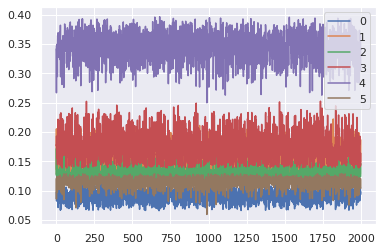

In [15]:
pd.DataFrame(mcmc.get_samples()["w"].mean(axis=0)).plot()

In [16]:
f_test = mcmc.get_samples()["f_test"]
S, n_test, _ = f_test.shape
S, n_test

(4000, 1020)

In [17]:
w_test = jax.nn.softmax(f_test, axis=2).mean(axis=0)
w_test

DeviceArray([[0.09194063, 0.1613793 , 0.13687995, 0.1583447 , 0.32552654,
              0.1259289 ],
             [0.09483032, 0.19760047, 0.1489839 , 0.14440298, 0.3071916 ,
              0.10699071],
             [0.092498  , 0.17142291, 0.13549002, 0.14878489, 0.3402575 ,
              0.1115467 ],
             ...,
             [0.10058457, 0.1383016 , 0.12682638, 0.17196593, 0.34006023,
              0.12226129],
             [0.08246917, 0.12808862, 0.12771404, 0.1905026 , 0.34954613,
              0.12167947],
             [0.07810371, 0.11252597, 0.11289838, 0.20867297, 0.38571462,
              0.10208435]], dtype=float32)

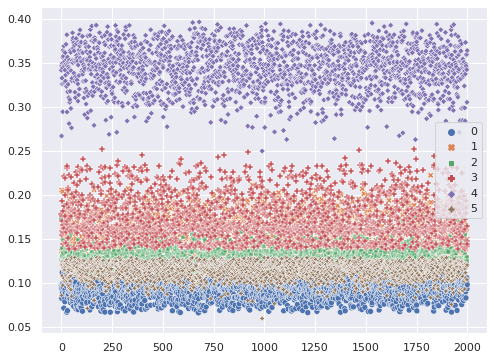

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(w), ax=ax);

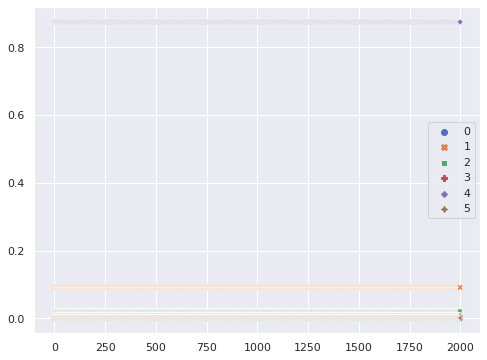

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(np.hstack([scipy.special.softmax(lpd_point.sum(axis=0))[:, np.newaxis] for _ in range(2000)]).T));

In [20]:
train_x_list[2]

# array([[1.        , 0.0737    , 1.5       , ..., 0.        , 1.        ,
#         0.        ],
#        [1.        , 0.89266998, 2.14      , ..., 0.        , 0.        ,
#         0.        ],
#        [1.        , 0.84168999, 1.65      , ..., 0.        , 1.        ,
#         0.        ],
#        ...,
#        [1.        , 0.08824   , 0.74      , ..., 1.        , 0.        ,
#         0.        ],
#        [1.        , 1.38309998, 2.04      , ..., 0.        , 1.        ,
#         0.        ],
#        [1.        , 0.27764999, 3.43      , ..., 0.        , 0.        ,
#         0.        ]])

array([[1.        , 0.66454002, 1.14      , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 1.73871994, 3.73      , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.29954   , 0.86      , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 0.50347   , 2.05      , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.97403   , 3.44      , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.13573   , 1.71      , ..., 0.        , 0.        ,
        0.        ]])

## 8. Make predictions

In [23]:
train_preds = []
for k in range(K):
    train_pred = numpyro.infer.Predictive(logistic, fit_list[k].get_samples())
    train_preds.append(
        train_pred(jax.random.PRNGKey(0), x=train_x_list[k])[
            "logits"
        ].mean(axis=0)
    )
train_preds = np.vstack(train_preds).T

In [25]:
preds = []
for k in range(K):
    post_pred = numpyro.infer.Predictive(logistic, fit_list[k].get_samples())
    preds.append(
        post_pred(jax.random.PRNGKey(0), x=train_x_test_list[k])[
            "logits"
        ].mean(axis=0)
    )
preds = np.vstack(preds).T

In [26]:
pooled_predictions = (w_test * preds).sum(axis=1)

In [27]:
pooled_predictions.shape

(1020,)

## 9. Predict on test set

## use hierarchical stacking

In [29]:
numpyro.distributions.Bernoulli(logits=pooled_predictions).log_prob(
    y_test
).mean()

DeviceArray(-0.6481451, dtype=float32)

## using model with best lpd (model selection)

In [30]:
numpyro.distributions.Bernoulli(
    logits=preds[:, lpd_point.sum(axis=0).argmax()]
).log_prob(y_test).mean()

DeviceArray(-0.65147495, dtype=float32)

## using stacking (weights don't vary over input)

In [31]:
numpyro.distributions.Bernoulli(
    logits=(jax.nn.softmax(lpd_point.sum(axis=0)) * preds).sum(axis=1)
).log_prob(y_test).mean()

DeviceArray(-0.6506303, dtype=float32)

## using simple model averaging

In [32]:
numpyro.distributions.Bernoulli(logits=preds.mean(axis=1)).log_prob(
    y_test
).mean()

DeviceArray(-0.64853245, dtype=float32)

In [33]:
lpd_point

array([[-0.78843307, -0.75373268, -0.71037483, -0.80408859, -0.62251377,
        -0.64853287],
       [-0.93144035, -0.80958652, -0.73193264, -0.78938961, -0.87590694,
        -0.89203644],
       [-0.85188198, -0.8355732 , -0.85257339, -1.03882217, -1.05034924,
        -0.84100914],
       ...,
       [-0.79784393, -0.89944172, -0.92439556, -0.90409088, -0.76911259,
        -0.96490097],
       [-1.10281181, -1.05095291, -0.97271633, -1.06927109, -0.93566132,
        -1.18956852],
       [-0.98854733, -1.11856651, -1.17337418, -1.28518009, -1.07299614,
        -1.00991535]])

In [34]:
train_x_list

[array([[1.        , 0.66454002, 1.14      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 1.73871994, 3.73      , ..., 0.        , 1.        ,
         0.        ],
        [1.        , 0.29954   , 0.86      , ..., 0.        , 1.        ,
         0.        ],
        ...,
        [1.        , 0.50347   , 2.05      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 0.97403   , 3.44      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 0.13573   , 1.71      , ..., 0.        , 0.        ,
         0.        ]]),
 array([[ 1.        ,  0.66454002,  0.13102826, ...,  1.        ,
          0.        ,  0.        ],
        [ 1.        ,  1.73871994,  1.31640823, ...,  0.        ,
          1.        ,  0.        ],
        [ 1.        ,  0.29954   , -0.15082289, ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [ 1.        ,  0.50347   ,  0.71783979, ...,  1.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.97403   ,  1.23547147, ...,  1.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.13573   ,  0.53649337, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[1.        , 0.66454002, 1.14      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 1.73871994, 3.73      , ..., 0.        , 1.        ,
         0.        ],
        [1.        , 0.29954   , 0.86      , ..., 0.        , 1.        ,
         0.        ],
        ...,
        [1.        , 0.50347   , 2.05      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 0.97403   , 3.44      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 0.13573   , 1.71      , ..., 0.        , 0.        ,
         0.        ]]),
 array([[1.00000000e+00, 6.64540024e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.73871994e+00, 0.00000000e+00, ...,
         4.98721271e-01, 1.23224254e-01, 2.81991407e-03],
        [1.00000000e+00, 2.99540005e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.00000000e+00, 5.03470001e-01, 1.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 9.74029999e-01, 0.00000000e+00, ...,
         4.53328221e-01, 6.68768142e-02, 3.16678514e-04],
        [1.00000000e+00, 1.35730000e-01, 1.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([[ 1.        ,  0.13102826,  0.        , ...,  0.00305231,
          0.        ,  0.        ],
        [ 1.        ,  1.31640823,  0.        , ...,  0.46955435,
          0.24825786,  0.03149146],
        [ 1.        , -0.15082289,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.        ,  0.71783979,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        ,  1.23547147,  0.        , ...,  0.20875252,
          0.00847085,  0.        ],
        [ 1.        ,  0.53649337,  1.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 1.        ,  0.66454002,  0.13102826,  0.        ,  5.        ],
        [ 1.        ,  1.73871994,  1.31640823,  0.        , 10.        ],
        [ 1.        ,  0.29954   , -0.15082289,  0.        ,  7.        ],
        ...,
        [ 1.        ,  0.50347   ,  0.71783979,  1.        ,  3.        ],
        [ 1.        ,  0.97403   ,  1.23547147,  0.        ,  5.        ],
        [ 1.        ,  0.13573   ,  0.53649337,  1.        ,  0.        ]])]

[array([[1.        , 0.66454002, 1.14      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 1.73871994, 3.73      , ..., 0.        , 1.        ,
         0.        ],
        [1.        , 0.29954   , 0.86      , ..., 0.        , 1.        ,
         0.        ],
        ...,
        [1.        , 0.50347   , 2.05      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 0.97403   , 3.44      , ..., 1.        , 0.        ,
         0.        ],
        [1.        , 0.13573   , 1.71      , ..., 0.        , 0.        ,
         0.        ]]),
 array([[ 1.        ,  0.66454002,  0.13102826, ...,  1.        ,
          0.        ,  0.        ],
        [ 1.        ,  1.73871994,  1.31640823, ...,  0.        ,
          1.        ,  0.        ],
        [ 1.        ,  0.29954   , -0.15082289, ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [ 1.        ,  0.50347   ,  0.71783979, ...,  1.        ,
          0.        ,  0

In [35]:
w_test

DeviceArray([[0.09194063, 0.1613793 , 0.13687995, 0.1583447 , 0.32552654,
              0.1259289 ],
             [0.09483032, 0.19760047, 0.1489839 , 0.14440298, 0.3071916 ,
              0.10699071],
             [0.092498  , 0.17142291, 0.13549002, 0.14878489, 0.3402575 ,
              0.1115467 ],
             ...,
             [0.10058457, 0.1383016 , 0.12682638, 0.17196593, 0.34006023,
              0.12226129],
             [0.08246917, 0.12808862, 0.12771404, 0.1905026 , 0.34954613,
              0.12167947],
             [0.07810371, 0.11252597, 0.11289838, 0.20867297, 0.38571462,
              0.10208435]], dtype=float32)

In [39]:
train_id.to_series()

1104    1104
1114    1114
2717    2717
1951    1951
1068    1068
        ... 
2005    2005
1051    1051
2354    2354
827      827
1021    1021
Length: 2000, dtype: int64